<a href="https://colab.research.google.com/github/zhaorutcd/bilibili_vlogs/blob/master/MonteCarloTreeSearch_ConnectX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### About ConnectX
* Connect 4 is a turn based game where two players drop coloured discs into a vertical grid alternatively. The aim of each player is to form a **sequence of four discs** in a row before its opponent. This is a **perfect information gam**e, meaning each player is well informed of all the events that have previously occured.


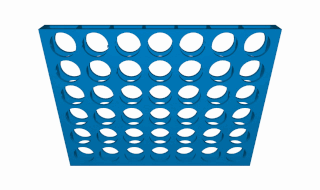

* Alternatively, Connect 4 can also be considered as a **zero-sum** game meaning there is no mutual win or loss.

### Kaggle environment to load ConnectX

*  Kaggle provides an amazingly easy to use OpenAI like gym environment for the Connect 4 game.

* In order to final test your agent you can also use predefined **random** and **negamax** agents.

In [ ]:
!pip install 'kaggle-environments>=0.1.6'

### Import Required libraries

In [ ]:
from kaggle_environments import evaluate, make, utils
import random
import math
import time
import inspect
import os

### "Loading environment football failed: No module named 'gfootball'" (Warning)

Loading environment football failed: No module named 'gfootball'


### Load the environment

In [ ]:
env = make("connectx", debug=True)
env.reset()

env.run(["random", "random"])
env.render(mode="ipython", width=500, height=450)

### Different Approach to solve the problem
There can be many different algorithms to solve this problem like
* Minimax
* Minimax with alpha beta pruning
* Q Learning
* Proximal Policy Algorithm
* Monte Carlo Tree Search
* and many more

I preferred using Monte Carlo Tree Search algorithm because of its flexibity to solve games with large branching factor. The main bottleneck for games involving large action space (7 in case of connect4 ) is that requires it requires an extensive search considering the different permutation and combination of the given board. MCTS tries to overcome this problem in an efficient way as explained below by reducing the search space while at the same time maintaing the efficiency.

### Monte Carlo Tree Search: Theory
**Idea** : Monte Carlo Tree Search builds a search tree with n nodes with each node annotated with the win count and the visit count. Initially the tree starts with a single root node and performs iterations as long as resources are not exhausted.
* **Initial Setup** - Start with a single root (parent) node and assign a large random UCB value to each non visited (child) nodes.

MCTS consists of four main steps
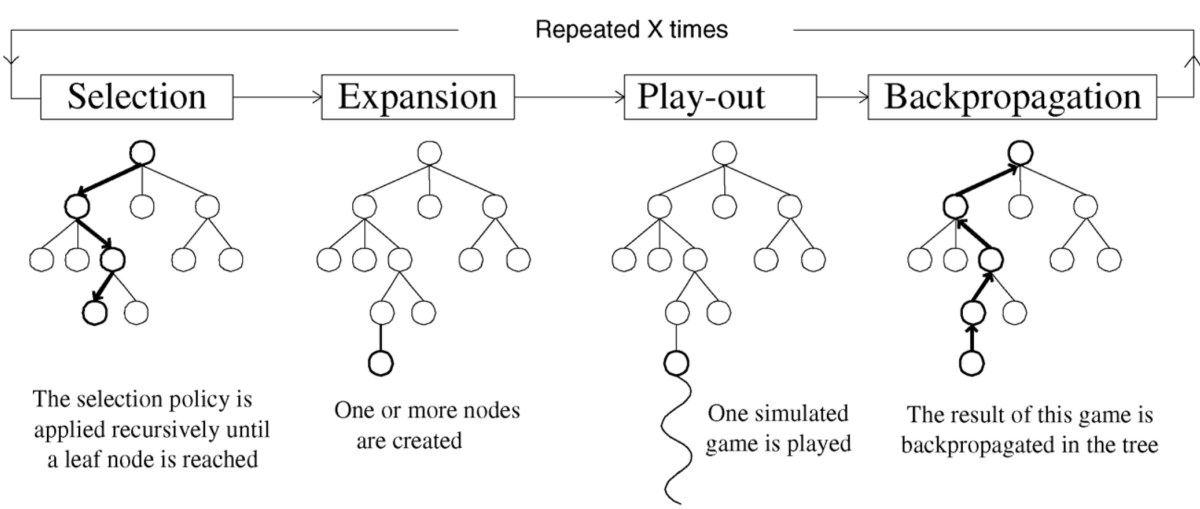
* **Selection** - In this phase the agent starts at the root node, selects the most urgent node, apply the chosen actions and continue till the terminal state is reached. To select the most urgent node upper confidence bound of the nodes are used. The node with the maximum UCB is used as the next node. The UCB process helps overcome exploration and exploitation dilemma. Also well known as Multi-Armed  bandit problem where the agent wants to maximise one's gains while playing (Lifelong Learning)
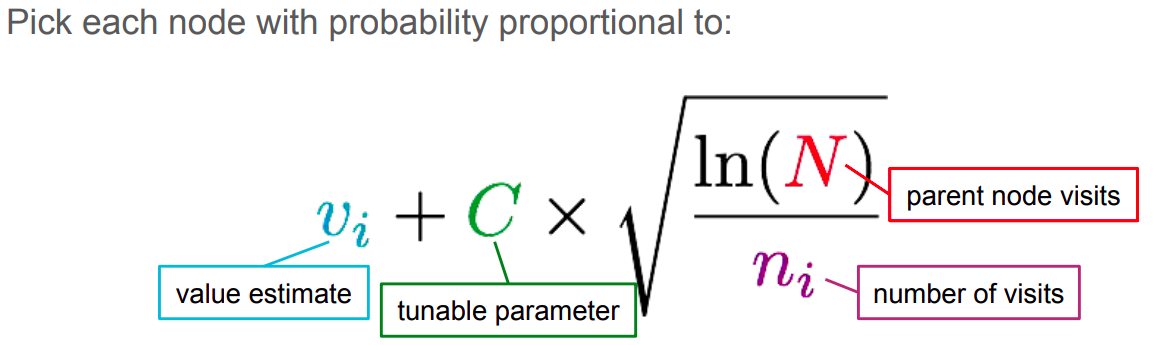
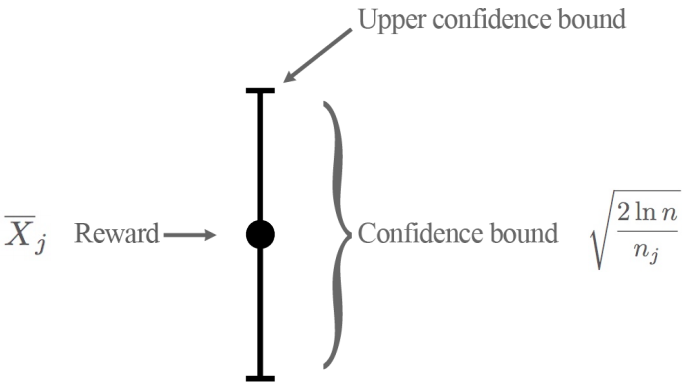

* **Expansion** - When UCB can no longer be applied to find the next node, the game tree is expanded further to include unexplored child by appending all possible nodes from the leaf node
* **Simulation** - Once expanded the algorithm selects the child node either randomly or with a policy until it reaches the final state of the game
* **Backpropagation** - When the agent reach the final state of the game with a winner, all the traversed node are updated. The visit and win score for each nodes are updated.

The above steps are repeated for some iterations.

* Finally the child of the root node with the highest number of visits is selected as the next action as more the number of visits higher is the ucb.




### MCTS Operation
* Each iteration starts at the root.
* Follows tree policy to reach a leaf node.
* Node 'N' is added.
* Perform a random rollout.
* Value backpropagated up the tree


### MCTS Agent to play connectX

In [ ]:
def connectx_agent(obs, config):

  import math
  import random
  import time
  import numpy as np

  def put_new_piece(grid, col, mark, config):
    next_state = grid.copy()
    for row in range(config.rows-1, -1, -1):
      if not next_state[row][col]:
        break
    next_state[row][col] = mark
    return next_state

  def check_result(grid, piece, config):

    def look_for_window(window):
      return (window.count(piece) == 4 and window.count(0) == config.inarow - 4)

    def calculate_windows():
      is_success = False
      sequences = ['horizontal', 'vertical', 'p_diagonal', 'n_diagonal']

      for sequence_type in sequences:

        if sequence_type == 'horizontal':
          for row in range(config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[row, col:col+config.inarow])
                if look_for_window(window):
                  return True

        elif sequence_type == 'vertical':
          for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns):
                window = list(grid[row:row+config.inarow, col])
                if look_for_window(window):
                  return True

        elif sequence_type == 'p_diagonal':
          for row in range(config.rows-(config.inarow-1)):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row+config.inarow), range(col, col+config.inarow)])
                if look_for_window(window):
                  return True

        elif  sequence_type == 'n_diagonal':
          for row in range(config.inarow-1, config.rows):
            for col in range(config.columns-(config.inarow-1)):
                window = list(grid[range(row, row-config.inarow, -1), range(col, col+config.inarow)])
                if look_for_window(window):
                  return True

      return is_success

    return calculate_windows()

  class MCTS():

    def __init__(self, obs, config):

      self.state = np.asarray(obs.board).reshape(config.rows, config.columns)
      self.config = config
      self.player = obs.mark
      self.final_action = None
      self.time_limit = self.config.timeout - 0.3
      self.root_node = (0,)
      self.tunable_constant = 1.0

      self.tree = {self.root_node:{'state':self.state, 'player':self.player,
                              'child':[], 'parent': None, 'total_node_visits':0,
                              'total_node_wins':0}}
      self.total_parent_node_visits = 0

    def get_ucb(self, node_no):
      if not self.total_parent_node_visits:
        return math.inf
      else:
        value_estimate = self.tree[node_no]['total_node_wins'] / (self.tree[node_no]['total_node_visits'] + 1)
        exploration = math.sqrt(2*math.log(self.total_parent_node_visits) / (self.tree[node_no]['total_node_visits'] + 1))
        ucb_score =  value_estimate + self.tunable_constant * exploration
        return ucb_score

    def selection(self):
      '''
      Aim - To select the leaf node with the maximum UCB
      '''
      is_terminal_state = False
      leaf_node_id = (0,)
      while not is_terminal_state:
        node_id = leaf_node_id
        number_of_child = len(self.tree[node_id]['child'])
        if not number_of_child:
          leaf_node_id = node_id
          is_terminal_state = True
        else:
          max_ucb_score = -math.inf
          best_action = leaf_node_id
          for i in range(number_of_child):
            action = self.tree[node_id]['child'][i]
            child_id = leaf_node_id + (action,)
            current_ucb = self.get_ucb(child_id)
            if current_ucb > max_ucb_score:
              max_ucb_score = current_ucb
              best_action = action
          leaf_node_id = leaf_node_id + (best_action,)
      return leaf_node_id

    def expansion(self, leaf_node_id):
      '''
      Aim - Add new nodes to the current leaf node by taking a random action
            and then take a random or follow any policy to take opponent's action.
      '''
      current_state = self.tree[leaf_node_id]['state']
      player_mark = self.tree[leaf_node_id]['player']
      current_board = np.asarray(current_state).reshape(config.rows*config.columns)
      self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]
      done = check_result(current_state, player_mark, self.config)
      child_node_id = leaf_node_id
      is_availaible = False

      if len(self.actions_available) and not done:
        childs = []
        for action in self.actions_available:
          child_id = leaf_node_id + (action,)
          childs.append(action)
          new_board = put_new_piece(current_state, action, player_mark, self.config)
          self.tree[child_id] = {'state': new_board, 'player': player_mark,
                                 'child': [], 'parent': leaf_node_id,
                                 'total_node_visits':0, 'total_node_wins':0}

          if check_result(new_board, player_mark, self.config):
            best_action = action
            is_availaible = True

        self.tree[leaf_node_id]['child'] = childs

        if is_availaible:
          child_node_id = best_action
        else:
          child_node_id = random.choice(childs)

      return leaf_node_id + (child_node_id,)

    def simulation(self, child_node_id):
      '''
      Aim - Reach the final state of the game
      '''
      self.total_parent_node_visits += 1
      state = self.tree[child_node_id]['state']
      previous_player = self.tree[child_node_id]['player']

      is_terminal = check_result(state, previous_player, self.config)
      winning_player = previous_player
      count = 0

      while not is_terminal:

        current_board = np.asarray(state).reshape(config.rows*config.columns)
        self.actions_available = [c for c in range(self.config.columns) if not current_board[c]]

        if not len(self.actions_available) or count==3:
          winning_player = None
          is_terminal = True

        else:
          count+=1
          if previous_player == 1:
            current_player = 2
          else:
            current_player = 1

          for actions in self.actions_available:
            state = put_new_piece(state, actions, current_player, self.config)
            result = check_result(state, current_player, self.config)
            if result: # A player won the game
              is_terminal = True
              winning_player = current_player
              break


        previous_player = current_player

      return winning_player

    def backpropagation(self, child_node_id, winner):
      '''
      Aim - Update the traversed nodes
      '''
      player = self.tree[(0,)]['player']

      if winner == None:
        reward = 0
      elif winner == player:
        reward = 1
      else:
        reward = -10

      node_id = child_node_id
      self.tree[node_id]['total_node_visits'] += 1
      self.tree[node_id]['total_node_wins'] += reward

    def start_the_game(self):
      '''
      Aim - Complete MCTS iteration with all the process running for some fixed time
      '''
      self.initial_time = time.time()
      is_expanded = False

      while time.time() - self.initial_time < self.time_limit:
        node_id = self.selection()
        if not is_expanded:
          node_id = self.expansion(node_id)
          is_expanded = True
        winner = self.simulation(node_id)
        self.backpropagation(node_id, winner)

      current_state_node_id = (0,)
      action_candidates = self.tree[current_state_node_id]['child']
      total_visits = -math.inf
      for action in action_candidates:
        action = current_state_node_id + (action,)
        visit = self.tree[action]['total_node_visits']
        if visit > total_visits:
          total_visits = visit
          best_action = action

      return best_action

  my_agent = MCTS(obs, config)

  return my_agent.start_the_game()[1]


### Validate Agent

In [ ]:
env = make("connectx", debug=True)

env.reset()

env.run(['negamax', connectx_agent])
x = env.render(mode="ipython", width=500, height=450)

### Other common approach
* Other common approach Minimax with alpha beta pruning.
   
   **Idea** - If beta's (minimizing player) maximum score becomes less than the minimum score of the maximizing player(alpha) , the maximizing player is not required to consider other nodes.
  * Works well when:
    *  a good heuristic value function is known
    * The branching factor is modest.